In [1]:
pip install pmdarima ta yfinance pykalman


Note: you may need to restart the kernel to use updated packages.


In [32]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ta.volatility import BollingerBands
from pykalman import KalmanFilter
from pmdarima import auto_arima
import warnings

warnings.filterwarnings("ignore")
# Step 1: Download the data
data = yf.download('^GSPC', start='2010-01-01', end='2025-04-12')

# Step 2: Compute indicators
data['SMA_crossover'] = data['Close'].rolling(window=50).mean() - data['Close'].rolling(window=10).mean()

def stochastic_oscillator(df, window=14):
    low_min = df['Low'].rolling(window).min()
    high_max = df['High'].rolling(window).max()
    df['%K'] = 100 * ((df['Close'] - low_min) / (high_max - low_min))
    return df

data = stochastic_oscillator(data)

def average_true_range(df, window=14):
    high_low = df['High'] - df['Low']
    high_close = abs(df['High'] - df['Close'].shift(1))
    low_close = abs(df['Low'] - df['Close'].shift(1))
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['ATR_14'] = true_range.rolling(window).mean()  # SMA of TR
    return df

data = average_true_range(data)  

def on_balance_volume(df):
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).cumsum()
    return df

data = on_balance_volume(data)  # Adds OBV column

def vwap(df):
    df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()
    return df

data = vwap(data)  # Adds VWAP column

delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI_14'] = 100 - (100 / (1 + rs))

ema_12 = data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = ema_12 - ema_26

data['Return'] = data['Close'].pct_change()
data['Volatility'] = data['Return'].rolling(window=10).std()

bb_indicator = BollingerBands(close=data['Close'].squeeze(), window=20, window_dev=2)
data['BB_bandWidh'] = bb_indicator.bollinger_hband() - bb_indicator.bollinger_lband()

data['Return_3'] = data['Close'].pct_change(3).shift(1)  # 3-day cumulative return
data['Return_5'] = data['Close'].pct_change(5).shift(1)  # 5-day cumulative return
data['SMA_17'] = data['Close'].rolling(window=17).mean()
data['SMA_5'] = data['Close'].rolling(window=5).mean()
data['SMA_9'] = data['Close'].rolling(window=9).mean()
data['Volatility_Trend'] = data['Volatility'] - data['Volatility'].shift(1)

data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['MACD_Histogram'] = data['MACD'] - data['MACD_Signal']

shifted_close = data['Close'].shift(-3)


valid_idx = shifted_close.dropna().index
valid_values = shifted_close.dropna().values

kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=valid_values[0],
    initial_state_covariance=1.0,
    observation_covariance=1.0,
    transition_covariance=0.1
)

# Run Kalman filter only on non-NaN values
target_filtered, _ = kf.filter(valid_values)

# Assign back to DataFrame using original index
target_series = pd.Series(target_filtered.flatten(), index=valid_idx)
data['Target'] = target_series

data.dropna(inplace=True)
# Step 3: Prepare Target time series
ts_data = data['Target']

# Step 4: Train-Test Split
train_size = int(len(ts_data) * 0.9)
train, test = ts_data[:train_size], ts_data[train_size:]


[*********************100%***********************]  1 of 1 completed


                               SARIMAX Results                                
Dep. Variable:                 Target   No. Observations:                 3411
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -12020.858
Date:                Wed, 16 Apr 2025   AIC                          24051.717
Time:                        20:25:46   BIC                          24082.389
Sample:                             0   HQIC                         24062.678
                               - 3411                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6566      0.130      5.053      0.000       0.402       0.911
ar.L2          0.0181      0.097      0.186      0.853      -0.172       0.209
ma.L1         -0.0209      0.129     -0.162      0.8

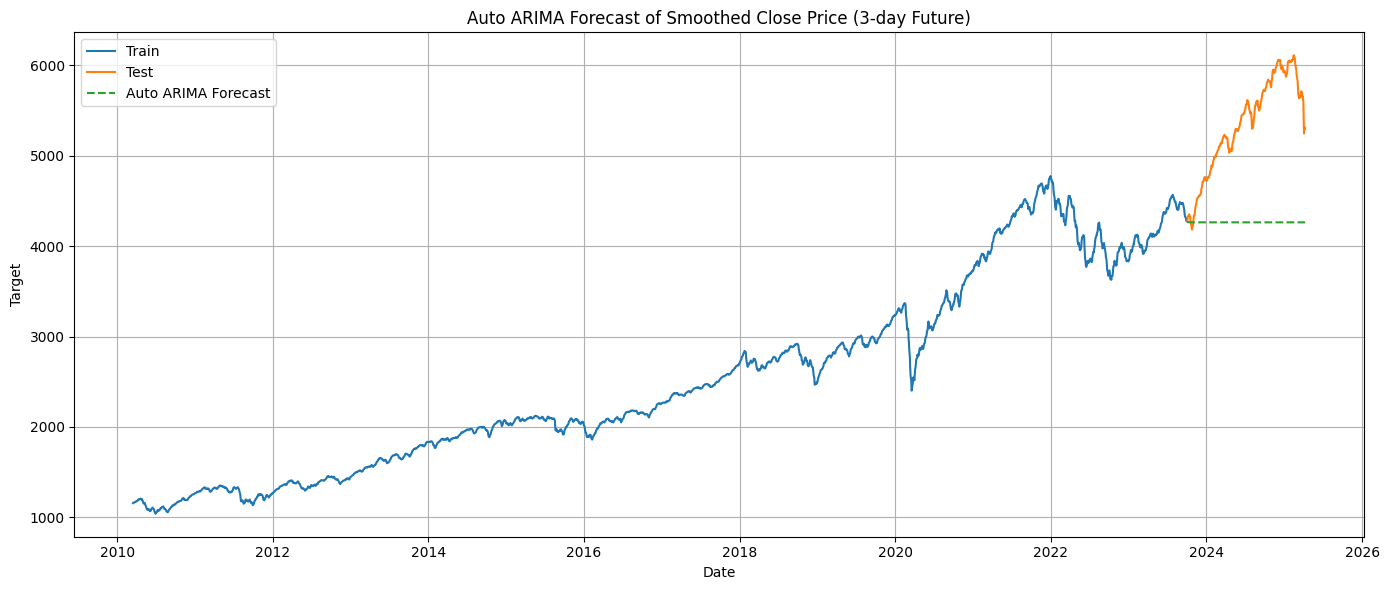

In [29]:
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

# Fit Auto ARIMA
model = ARIMA(train, order=(2,1,2))  # ARIMA(p,d,q)
model_fit = model.fit()
print(model_fit.summary())

# Predict only if model fitted
forecast_steps = len(test)
# Ensure the start and end arguments are integers relative to the training data
start = len(train)  # Start prediction from the end of the training data
end = start + len(test) - 1  # End prediction at the length of the test data

# Predict using the ARIMA model
forecast = model_fit.predict(start=start, end=end)

# Align the forecast index with the test data index
forecast = pd.Series(forecast.values, index=test.index)

# Ensure forecast is a Series with correct index
forecast = pd.Series(forecast, index=test.index)

# Drop NaNs if any still exist
valid_idx = (~test.isna()) & (~forecast.isna())
if valid_idx.sum() == 0:
    raise ValueError("No valid samples for evaluation: forecast is all NaNs.")

# Evaluate
rmse = np.sqrt(mean_squared_error(test[valid_idx], forecast[valid_idx]))
mae = mean_absolute_error(test[valid_idx], forecast[valid_idx])
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

plt.figure(figsize=(14,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(forecast.index, forecast, label='Auto ARIMA Forecast', linestyle='--')
plt.title('Auto ARIMA Forecast of Smoothed Close Price (3-day Future)')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



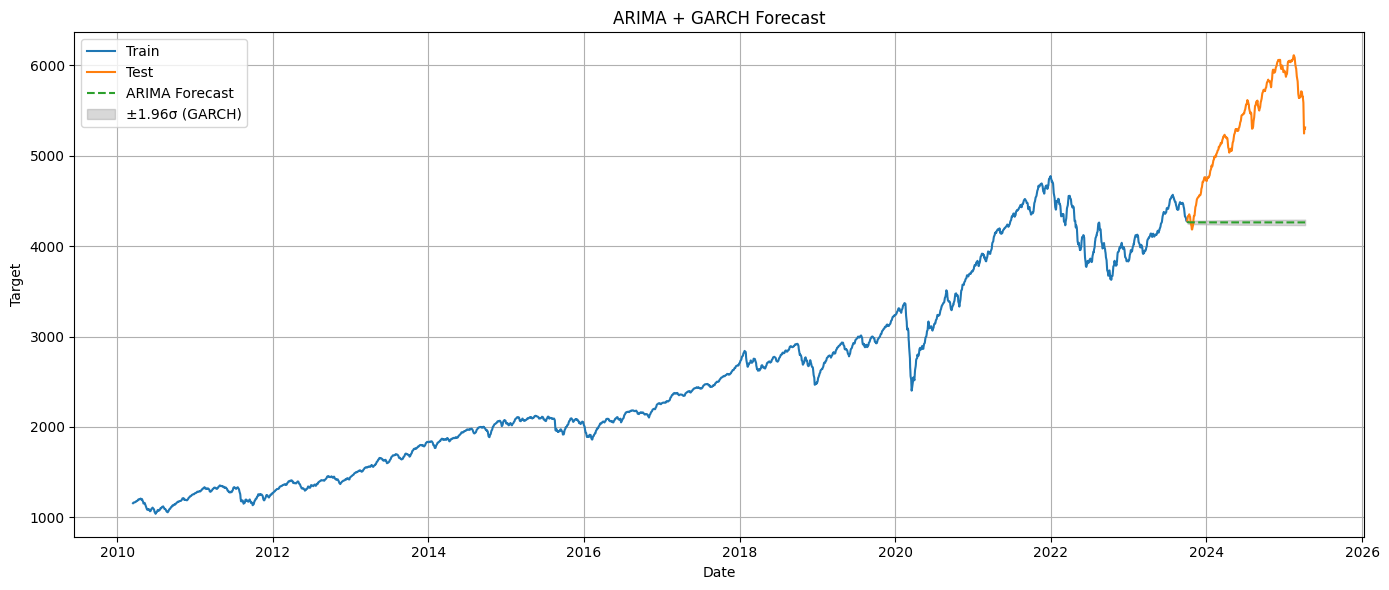

In [48]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA to model the mean
arima_model = ARIMA(train, order=(5,1,2))
arima_result = arima_model.fit()

# Get residuals (mean-corrected errors)
residuals = arima_result.resid

from arch import arch_model

# GARCH(1,1) model on residuals
garch_model = arch_model(residuals, vol='Garch', p=1, q=1)
garch_result = garch_model.fit(disp="off")

# Forecast future variance
garch_forecast = garch_result.forecast(horizon=len(test), reindex=False)


# Mean forecast from ARIMA
forecast_mean = arima_result.forecast(steps=len(test))

# Volatility (standard deviation) forecast from GARCH
forecast_vol = np.sqrt(garch_forecast.variance.values[-1])

# Construct confidence intervals if needed
upper = forecast_mean + 1.96 * forecast_vol
lower = forecast_mean - 1.96 * forecast_vol

plt.figure(figsize=(14,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast_mean, label='ARIMA Forecast', linestyle='--')
plt.fill_between(test.index, lower, upper, color='gray', alpha=0.3, label='±1.96σ (GARCH)')
plt.title('ARIMA + GARCH Forecast')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:

exog_features = ['SMA_crossover','SMA_17' ,'SMA_9','SMA_5','ATR_14', 'OBV', 'VWAP','Volume','BB_bandWidh','MACD','Volatility']
X = data[exog_features].values
y = data['Target'].values.reshape(-1, 1)

df = data.dropna(subset=['Target'] + exog_features)


KeyError: ['Target', 'SMA_crossover', 'SMA_17', 'SMA_9', 'SMA_5', 'ATR_14', 'OBV', 'VWAP', 'Volume', 'BB_bandWidh', 'MACD', 'Volatility']

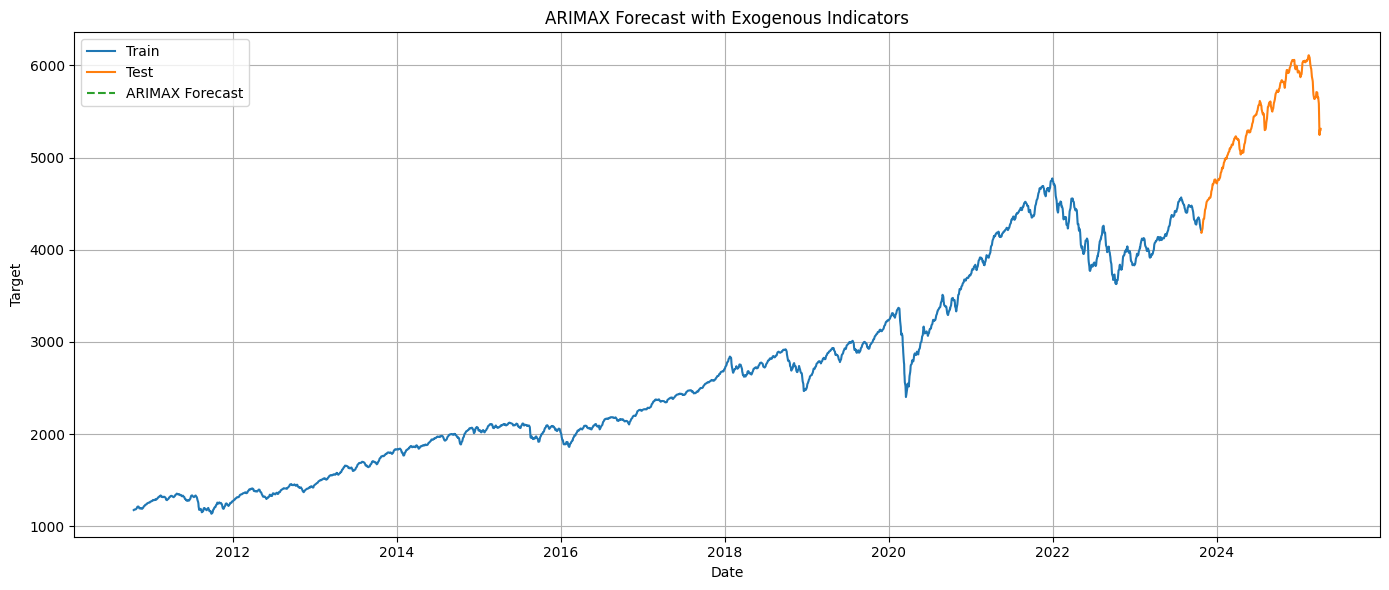

In [11]:
from sklearn.model_selection import train_test_split

y = data['Target']
X = data[exog_features]

train_size = int(len(data) * 0.9)
y_train, y_test = y[:train_size], y[train_size:]
X_train, X_test = X[:train_size], X[train_size:]

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit ARIMAX with exogenous features
arimax_model = SARIMAX(
    endog=y_train,
    exog=X_train,
    order=(2, 1, 2),  # start simple, tune later
    enforce_stationarity=False,
    enforce_invertibility=False
)
arimax_result = arimax_model.fit(disp=False)

forecast = arimax_result.predict(start=len(y_train), end=len(y)-1, exog=X_test)
forecast = pd.Series(forecast, index=y_test.index)

import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(forecast.index, forecast, label='ARIMAX Forecast', linestyle='--')
plt.title('ARIMAX Forecast with Exogenous Indicators')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


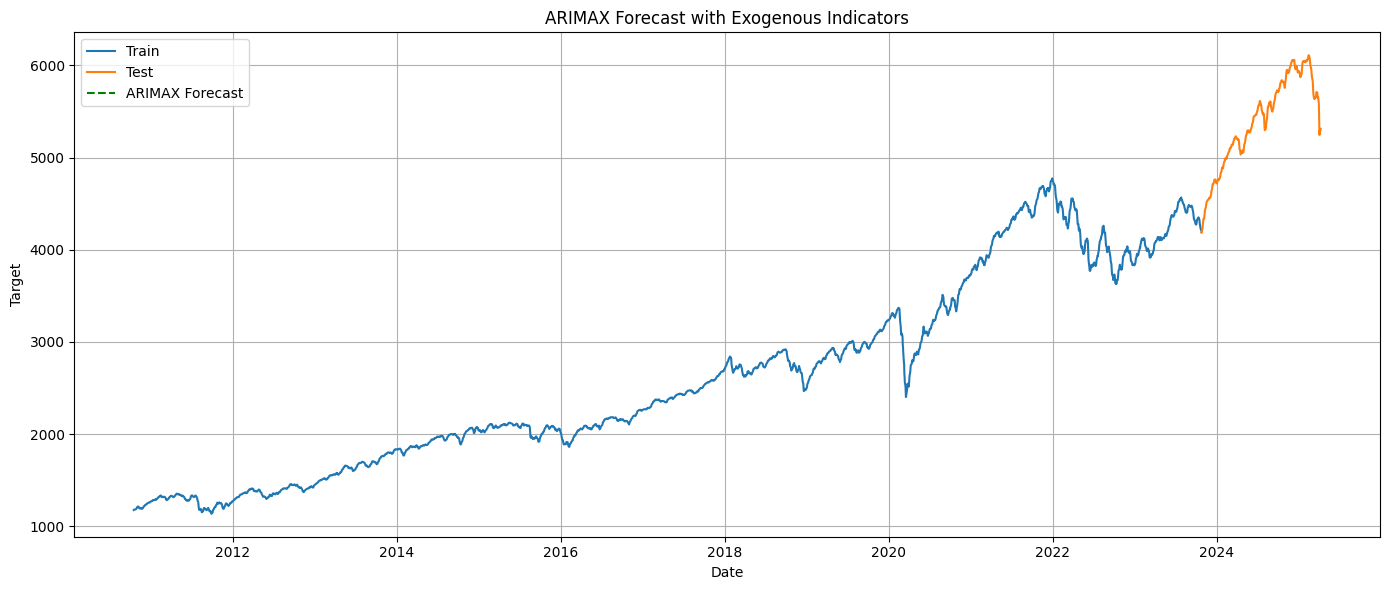

In [33]:
# Forecast over the test range
forecast = arimax_result.predict(
    start=len(y_train), 
    end=len(y_train) + len(y_test) - 1, 
    exog=X_test
)

forecast = pd.Series(forecast, index=y_test.index)

plt.figure(figsize=(14,6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(forecast.index, forecast, 'g--', label='ARIMAX Forecast')
plt.scatter(forecast.index, forecast, color='green', s=5)  # Add dots for clarity
plt.title('ARIMAX Forecast with Exogenous Indicators')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [30]:
exog_features = ['SMA_crossover','ATR_14', 'OBV', 'VWAP','Volume','BB_bandWidh','MACD','Volatility']

data[exog_features + ['Target']].corr()['Target'].sort_values(ascending=False)


Price          Ticker
Target                   1.000000
VWAP                     0.979313
OBV                      0.947770
ATR_14                   0.642304
BB_bandWidh              0.586545
MACD                     0.189150
Volume         ^GSPC     0.168612
Volatility              -0.009618
SMA_crossover           -0.196219
Name: Target, dtype: float64

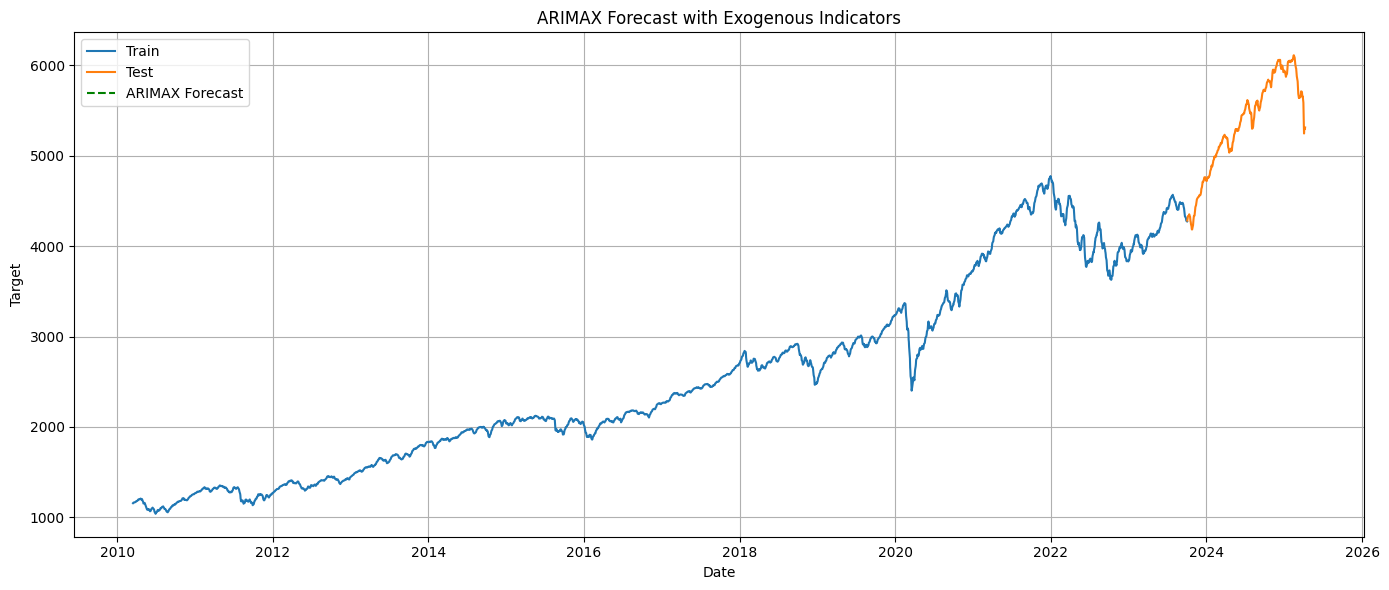

In [47]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define exogenous variables
exog_features = ['VWAP', 'OBV', 'ATR_14', 'BB_bandWidh', 'MACD', 'SMA_crossover']

dt = data[exog_features + ['Target']].dropna()
#df = data.dropna(subset=['Target'] + exog_features)

X = dt[exog_features]
y = dt['Target']

# Split
train_size = int(len(data) * 0.9)
y_train, y_test = y[:train_size], y[train_size:]
X_train, X_test = X[:train_size], X[train_size:]

X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)

# Fit ARIMAX
model = SARIMAX(y_train, exog=X_train, order=(5, 0, 1), enforce_stationarity=False, enforce_invertibility=False)
result = model.fit(disp=False)


# ✅ Correct forecast range
start = len(y_train)
end = len(y_train) + len(y_test) - 1
try:
    forecast = result.predict(start=len(y_train), end=len(y)-1, exog=X_test)
    forecast = pd.Series(forecast, index=y_test.index)
except Exception as e:
    print("Forecasting error:", e)

# ✅ Align forecast index to y_test
forecast = pd.Series(forecast, index=y_test.index)

# ✅ Plot to verify
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(forecast.index, forecast, 'g--', label='ARIMAX Forecast')
plt.scatter(forecast.index, forecast, color='green', s=5)
plt.title('ARIMAX Forecast with Exogenous Indicators')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [45]:
print("Model fitted params:\n", result.params)
print("Forecast sample:\n", forecast.head(5))
print("Forecast shape:", forecast.shape)
print("Forecast NaNs:", forecast.isna().sum())
print("Forecast unique values:", forecast.unique())

Model fitted params:
 VWAP             1.578538e+00
OBV              7.069729e-11
ATR_14          -4.270841e-01
BB_bandWidh     -8.264556e-03
MACD             7.897013e-01
SMA_crossover   -7.761700e-02
ar.L1            5.647710e-01
ma.L1            3.186010e-02
sigma2           7.345256e+01
dtype: float64
Forecast sample:
 Date
2023-10-03   NaN
2023-10-04   NaN
2023-10-05   NaN
2023-10-06   NaN
2023-10-09   NaN
Name: predicted_mean, dtype: float64
Forecast shape: (380,)
Forecast NaNs: 380
Forecast unique values: [nan]


In [49]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import yfinance as yf

prices = data['Close'].values.reshape(-1, 1)

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(prices)

# Create sequences
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i])
X, y = np.array(X), np.array(y)

# Train-test split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Predict future prices
last_sequence = scaled_data[-sequence_length:]
future_prices = []
for _ in range(30):  # Predict 30 days
    pred = model.predict(last_sequence.reshape(1, sequence_length, 1))
    future_prices.append(pred[0, 0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = pred
future_prices = scaler.inverse_transform(np.array(future_prices).reshape(-1, 1))

2025-04-17 00:11:56.637116: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-04-17 00:11:56.637154: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-17 00:11:56.637160: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-17 00:11:56.637345: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-17 00:11:56.637360: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/20


2025-04-17 00:11:58.397120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0185 - val_loss: 6.7682e-04
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.6042e-04 - val_loss: 7.4821e-04
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.6563e-04 - val_loss: 0.0011
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.5206e-04 - val_loss: 9.5867e-04
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.6024e-04 - val_loss: 7.4971e-04
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.4812e-04 - val_loss: 9.2288e-04
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.5380e-04 - val_loss: 6.1641e-04
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.3793e-04 - val_loss: 6.9834e-04
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.4992e-04 - val_loss: 5.2658e-04
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.2633e-04 - val_loss: 7.1582e-04
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.4644e-04 - val_loss: 6.539

In [55]:
# Assume predicted_prices is a DataFrame with predicted prices for multiple assets
future_prices_df = pd.DataFrame(future_prices)
returns = future_prices_df.pct_change().dropna()
expected_returns = returns.mean() * 252  # Annualized returns
cov_matrix = returns.cov() * 252  # Annualized covariance matrix

In [56]:
from scipy.optimize import minimize
import numpy as np

# Define portfolio metrics
def portfolio_performance(weights, returns, cov_matrix, risk_free_rate=0.01):
    port_return = np.sum(returns * weights) * 252
    port_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    sharpe_ratio = (port_return - risk_free_rate) / port_std
    return port_return, port_std, sharpe_ratio

# Objective: Maximize Sharpe ratio
def neg_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate):
    return -portfolio_performance(weights, returns, cov_matrix, risk_free_rate)[2]

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Sum of weights = 1
bounds = tuple((0, 1) for _ in range(len(expected_returns)))  # Weights between 0 and 1

# Optimize
init_weights = np.array([1/len(expected_returns)] * len(expected_returns))
result = minimize(neg_sharpe_ratio, init_weights, args=(expected_returns, cov_matrix, 0.01),
                  method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = result.x

# Output results
port_return, port_std, sharpe_ratio = portfolio_performance(optimal_weights, expected_returns, cov_matrix)
print(f"Optimal Weights: {optimal_weights}")
print(f"Expected Return: {port_return:.4f}, Volatility: {port_std:.4f}, Sharpe Ratio: {sharpe_ratio:.4f}")

Optimal Weights: [1.]
Expected Return: -22.3814, Volatility: 1.1379, Sharpe Ratio: -19.6774


In [62]:
import matplotlib.pyplot as plt

# Simulate random portfolios
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
weights_record = []
for i in range(num_portfolios):
    weights = np.random.random(len(expected_returns))
    weights /= np.sum(weights)
    results[:, i] = portfolio_performance(weights, expected_returns, cov_matrix)
    weights_record.append(weights)

In [61]:
import pandas as pd
import numpy as np

# Assume predicted_prices is a DataFrame with predicted prices for assets (columns)
returns = (future_prices_df.iloc[-1] - future_prices_df.iloc[0]) / future_prices_df.iloc[0] * 100

# Label trends
def label_trend(return_val, bull_threshold=5, bear_threshold=-5):
    if return_val > bull_threshold:
        return 'Bullish'
    elif return_val < bear_threshold:
        return 'Bearish'
    else:
        return 'Neutral'

trends = returns.apply(label_trend)
print("Asset Trends:\n", trends)

Asset Trends:
 0    Neutral
dtype: object
